In [58]:
import pandas as pd
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mn

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix,classification_report


## 1- Load data

In [2]:
train_df=pd.read_csv('train.csv')
gen_df=pd.read_csv('gender_submission.csv')
test_df=pd.read_csv('test.csv')

#Putting train data and test in array so that data cleaning and new feature creation will be done in one go.
data_arr=[train_df,test_df]

## 2- Variables identification:

    output:
        - Survived : cat*
    inputs : 
        - Pclass : cat
        - Sex : cat
        - Age : cont**
        - SibSp : cont
        - Parch : cat
        - Fare : cont
        - Embarked : cat
        
*: categorical

**: continuous 


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 3- Univariate analysis

In [82]:
train_df.describe()

,Survived,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_Misc,Title_Miss,...,FareBin_2,FareBin_3,FareBin_4,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_X
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,1.904602,0.602694,0.647587,0.086420,0.725028,0.206510,0.551066,0.030303,0.204265,...,0.251403,0.249158,0.249158,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.772166
std,0.486592,1.613459,0.489615,0.477990,0.281141,0.446751,0.405028,0.497665,0.171516,0.403390,...,0.434063,0.432769,0.432769,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.419670
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 5 - check if missing values

In [6]:
#Lets figure out which columns have null values.
colms=[col for col in train_df.columns if train_df[col].isnull().any()]
#colms=[col for col in test_df.columns if test_df[col].isnull().any()]
print(colms)

['Age', 'Cabin', 'Embarked']


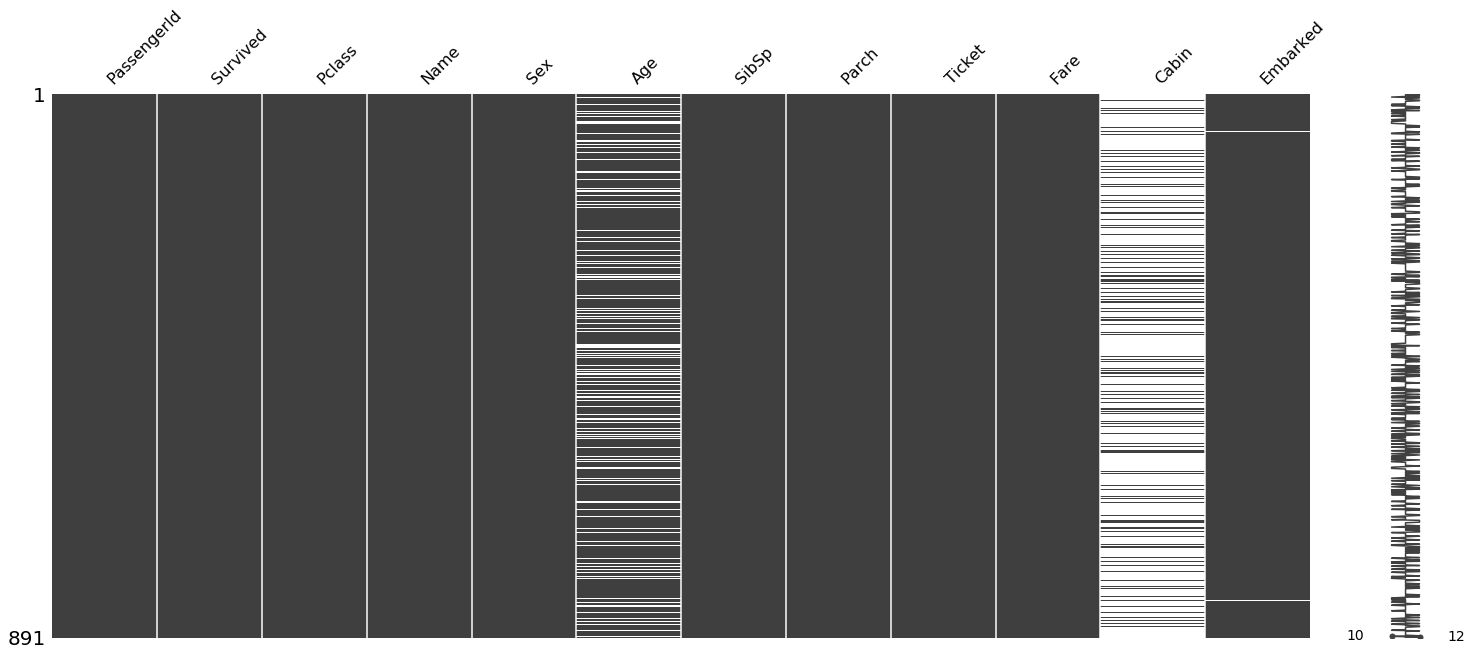

In [31]:
#Lets visualize null values in columns.
mn.matrix(train_df)
#mn.matrix(test_df)
#We can also use seaborn (may have issues with categorical data)
#plt.subplots(figsize=(9,6))
#sns.heatmap(train_df.isnull())

We should drop the Cabin column since it has very less value, for now lets replace the null value with X and visualise the servial prediction.

In [32]:
train_df['Cabin']=pd.Series([i[0] if pd.notnull(i) else 'X' for i in train_df['Cabin'] ])
train_df['Cabin'].replace('T','X',inplace=True) # I am replacing cabin T with X since there is no T cabin in test data.
test_df['Cabin']=pd.Series([i[0] if pd.notnull(i) else 'X' for i in test_df['Cabin'] ])
print(train_df.Cabin.value_counts())
#print(test_df.Cabin.unique())

X    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Cabin, dtype: int64


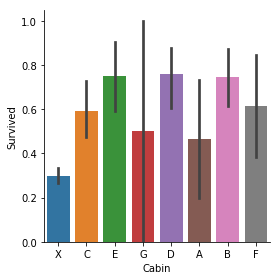

In [33]:
sns.factorplot(y='Survived',x='Cabin',data=train_df,kind='bar')
plt.show()

As you can see from the above plot, the passangers who were in cabins are more likly to survive as compared to non cabin passangers(X).

In [35]:
#sns.heatmap(train_df.isnull())
for data in data_arr:
    data['Title']=data.Name.str.split(', ',expand=True)[1].str.split('. ',expand=True)[0]
    title_cnt=data.Title.value_counts()<10
    data.Title=data.Title.apply(lambda x: x if title_cnt[x]==False else 'Misc')
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,Mr


In [36]:
#Lets update the null values in age.
med_age=pd.DataFrame()
def fill_age(cols):
    pclass=cols[0]
    sex=cols[1]
    age=cols[2]
    title=cols[3]
    if pd.isnull(age):
        return med_age[(med_age['Pclass']==pclass) & (med_age['Title']==title) & (med_age['Sex']==sex)]['Age']
    else:
        return age

In [37]:
for dataset in data_arr:
    med_age=dataset.groupby(['Pclass','Title','Sex'])['Age'].median().reset_index()
    dataset['Age']=dataset[['Pclass','Sex','Age','Title']].apply(fill_age,axis=1)
    #mode()[0] will get the most common value among the group
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['FamilySize']=dataset.SibSp+dataset.Parch+1
    dataset['IsAlone']=1
    dataset['IsAlone'].loc[dataset['FamilySize']>1]=0
    #distributing fare in almost equally in 4 group
    dataset['FareBin']=pd.qcut(dataset['Fare'],4,labels=[1,2,3,4])
    #Grouping age in 5 equal intervals
    dataset['AgeBin']=pd.cut(dataset['Age'],5,labels=[1,2,3,4,5])
    

C:\Users\Sakher\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Sakher\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in greater_equal
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Sakher\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in less_equal
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Sakher\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in less_equal
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\Sakher\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in greater_equal
 

Visualization

0    549
1    342
Name: Survived, dtype: int64


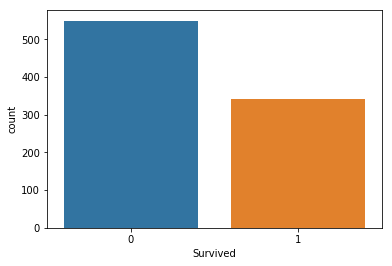

In [38]:
# 1.How many passanger survived.
print(train_df.Survived.value_counts())
sns.countplot(x='Survived',data=train_df)
plt.show()

Sex
female    233
male      109
Name: Survived, dtype: int64


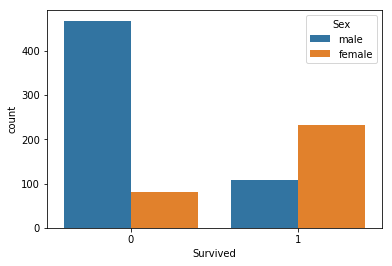

In [39]:
# 2.How many male and female survived.
print(train_df.groupby('Sex')['Survived'].sum())
sns.countplot(x='Survived',hue='Sex',data=train_df)
plt.show()

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64


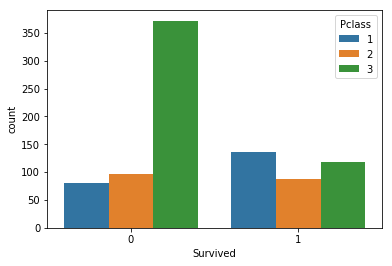

In [40]:
# 3.Find the survivers based on Class
print(train_df.groupby('Pclass')['Survived'].sum())
sns.countplot(x='Survived',hue='Pclass',data=train_df)
plt.show()

Title
Master     23
Misc       12
Miss      127
Mr         81
Mrs        99
Name: Survived, dtype: int64


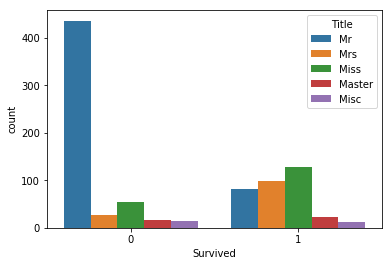

In [41]:
# 4.Find the Survivers based on Title
print(train_df.groupby('Title')['Survived'].sum())
sns.countplot(x='Survived',hue='Title',data=train_df)
plt.show()

IsAlone
0    179
1    163
Name: Survived, dtype: int64


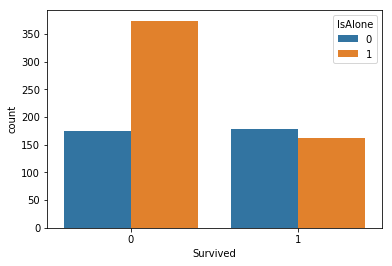

In [42]:
# 5.Find the survivers who were alone
print(train_df.groupby('IsAlone')['Survived'].sum())
sns.countplot(x='Survived',hue='IsAlone',data=train_df)
plt.show()

FamilySize
1     163
2      89
3      59
4      21
5       3
6       3
7       4
8       0
11      0
Name: Survived, dtype: int64


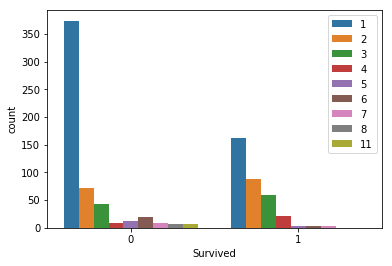

In [43]:
# 6.Find the survivers based on family size
print(train_df.groupby('FamilySize')['Survived'].sum())
sns.countplot(x='Survived',hue='FamilySize',data=train_df)
plt.legend(loc=1) #moving the legned to the right
plt.show()

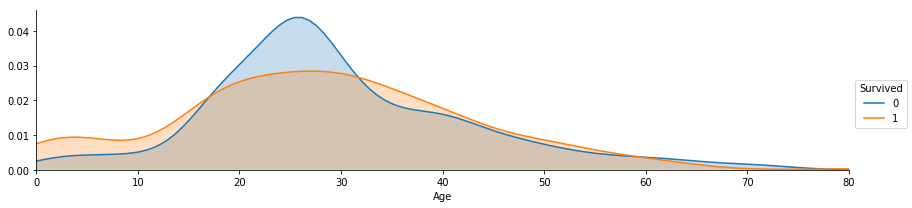

In [46]:
# 7.Plot a age distribution of passangers who survived.
train_df.Age=train_df.Age.astype(int)
ageplt=sns.FacetGrid(train_df,hue='Survived',aspect=4)
ageplt.map(sns.kdeplot,'Age',shade=True)
ageplt.set(xlim=(0,train_df.Age.max()))
ageplt.add_legend()
plt.show()

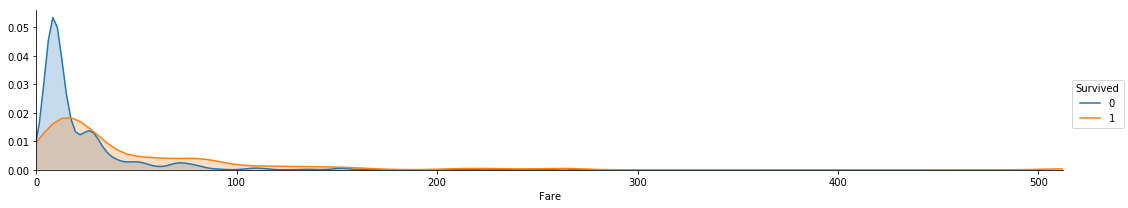

In [47]:
# 8.Plot a fare distribution of passangers who survived
fareplt=sns.FacetGrid(train_df,hue='Survived',aspect=5)
fareplt.map(sns.kdeplot,'Fare',shade=True)
fareplt.set(xlim=(0,train_df.Fare.max()))
fareplt.add_legend()
plt.show()

In [48]:
#Lets see the corelation matrix cofficient.
train_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
PassengerId,1.000000,-0.005007,-0.035144,0.042740,-0.057527,-0.001652,0.012658,-0.040143,0.057462
Survived,-0.005007,1.000000,-0.338481,-0.061909,-0.035322,0.081629,0.257307,0.016639,-0.203367
Pclass,-0.035144,-0.338481,1.000000,-0.416137,0.083081,0.018443,-0.549500,0.065997,0.135207
Age,0.042740,-0.061909,-0.416137,1.000000,-0.270292,-0.184922,0.121983,-0.277119,0.178680
SibSp,-0.057527,-0.035322,0.083081,-0.270292,1.000000,0.414838,0.159651,0.890712,-0.584471
Parch,-0.001652,0.081629,0.018443,-0.184922,0.414838,1.000000,0.216225,0.783111,-0.583398
Fare,0.012658,0.257307,-0.549500,0.121983,0.159651,0.216225,1.000000,0.217138,-0.271832
FamilySize,-0.040143,0.016639,0.065997,-0.277119,0.890712,0.783111,0.217138,1.000000,-0.690922
IsAlone,0.057462,-0.203367,0.135207,0.178680,-0.584471,-0.583398,-0.271832,-0.690922,1.000000


In [51]:
train_df.drop(['PassengerId','Ticket','Name','Fare','Age','SibSp','Parch'],axis=1,inplace=True)
test_df.drop(['Ticket','Name','Fare','Age','Parch','SibSp'],axis=1,inplace=True)
train_df.head()

,Survived,Pclass,Sex,Cabin,Embarked,Title,FamilySize,IsAlone,FareBin,AgeBin
0,0,3,male,X,S,Mr,2,0,1,2
1,1,1,female,C,C,Mrs,2,0,4,3
2,1,3,female,X,S,Miss,1,1,2,2
3,1,1,female,C,S,Mrs,2,0,4,3
4,0,3,male,X,S,Mr,1,1,2,3


In [52]:
#Lets incode the Sex and Embarked columns
train_df=pd.get_dummies(train_df,columns=['Sex','Embarked','Pclass','Title','AgeBin','FareBin','Cabin'],drop_first=True)
test_df=pd.get_dummies(test_df,columns=['Sex','Embarked','Pclass','Title','AgeBin','FareBin','Cabin'],drop_first=True)

In [53]:
train_df.corr()['Survived']

Survived      1.000000
FamilySize    0.016639
IsAlone      -0.203367
Sex_male     -0.543351
Embarked_Q    0.003650
Embarked_S   -0.149683
Pclass_2      0.093349
Pclass_3     -0.322308
Title_Misc    0.022030
Title_Miss    0.327093
Title_Mr     -0.549199
Title_Mrs     0.339040
AgeBin_2     -0.107068
AgeBin_3      0.032801
AgeBin_4      0.026859
AgeBin_5     -0.067344
FareBin_2    -0.095648
FareBin_3     0.084239
FareBin_4     0.233638
Cabin_B       0.175095
Cabin_C       0.114652
Cabin_D       0.150716
Cabin_E       0.145321
Cabin_F       0.057935
Cabin_G       0.016040
Cabin_X      -0.319572
Name: Survived, dtype: float64

In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
Survived      891 non-null int64
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Sex_male      891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
Pclass_2      891 non-null uint8
Pclass_3      891 non-null uint8
Title_Misc    891 non-null uint8
Title_Miss    891 non-null uint8
Title_Mr      891 non-null uint8
Title_Mrs     891 non-null uint8
AgeBin_2      891 non-null uint8
AgeBin_3      891 non-null uint8
AgeBin_4      891 non-null uint8
AgeBin_5      891 non-null uint8
FareBin_2     891 non-null uint8
FareBin_3     891 non-null uint8
FareBin_4     891 non-null uint8
Cabin_B       891 non-null uint8
Cabin_C       891 non-null uint8
Cabin_D       891 non-null uint8
Cabin_E       891 non-null uint8
Cabin_F       891 non-null uint8
Cabin_G       891 non-null uint8
Cabin_X       891 non-null uint8
dtypes: int64(3), uint8(23)
memory us

In [55]:
#Lets seperate input data and label data.
y=train_df['Survived']
X=train_df.iloc[:,1:] #taking all the columns except first.
PassengerId=test_df['PassengerId']
test_df.drop(labels=['PassengerId'],inplace=True,axis=1)

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.20,random_state=1)

In [66]:
from sklearn.linear_model import LogisticRegression
logmodel=LogisticRegression(max_iter=100)
logmodel.fit(X_train,y_train)
ypred=logmodel.predict(X_test)
print(logmodel.score(X_train,y_train))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.8412921348314607
[[91 15]
 [19 54]]
             precision    recall  f1-score   support

          0       0.83      0.86      0.84       106
          1       0.78      0.74      0.76        73

avg / total       0.81      0.81      0.81       179



In [67]:
from sklearn.svm import SVC
modelsvc=SVC(probability=True,gamma='auto')
modelsvc.fit(X_train,y_train)
ypred=modelsvc.predict(X_test)
print(modelsvc.score(X_train,y_train))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.8370786516853933
[[95 11]
 [23 50]]
             precision    recall  f1-score   support

          0       0.81      0.90      0.85       106
          1       0.82      0.68      0.75        73

avg / total       0.81      0.81      0.81       179



In [68]:
from sklearn.tree import DecisionTreeClassifier
dmodel=DecisionTreeClassifier()
dmodel.fit(X_train,y_train)
ypred=dmodel.predict(X_test)
print(dmodel.score(X_train,y_train))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.9143258426966292
[[95 11]
 [30 43]]
             precision    recall  f1-score   support

          0       0.76      0.90      0.82       106
          1       0.80      0.59      0.68        73

avg / total       0.77      0.77      0.76       179



In [69]:
from sklearn.ensemble import RandomForestClassifier
rmodel=RandomForestClassifier(n_estimators=50)
rmodel.fit(X_train,y_train)
ypred=rmodel.predict(X_test)
print(rmodel.score(X_train,y_train))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.9143258426966292
[[93 13]
 [26 47]]
             precision    recall  f1-score   support

          0       0.78      0.88      0.83       106
          1       0.78      0.64      0.71        73

avg / total       0.78      0.78      0.78       179



In [70]:
amodel=AdaBoostClassifier(n_estimators=100)
amodel.fit(X_train,y_train)
ypred=amodel.predict(X_test)
print(amodel.score(X_train,y_train))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.8356741573033708
[[87 19]
 [18 55]]
             precision    recall  f1-score   support

          0       0.83      0.82      0.82       106
          1       0.74      0.75      0.75        73

avg / total       0.79      0.79      0.79       179



In [71]:
gmodel=GradientBoostingClassifier(n_estimators=100)
gmodel.fit(X_train,y_train)
ypred=gmodel.predict(X_test)
print(gmodel.score(X_train,y_train))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.8876404494382022
[[94 12]
 [29 44]]
             precision    recall  f1-score   support

          0       0.76      0.89      0.82       106
          1       0.79      0.60      0.68        73

avg / total       0.77      0.77      0.76       179



In [72]:
#Here we are combining multiple estimators to get the voted prediction.
voting=VotingClassifier(estimators=[('logi',logmodel),('svc',modelsvc),('dtc',dmodel),('abc',amodel)],voting='soft',n_jobs=4)

In [73]:
voting=voting.fit(X_train,y_train)

In [74]:
pred1=voting.predict(test_df)
print(confusion_matrix(gen_df.Survived,pred1))
print(classification_report(gen_df.Survived,pred1))

[[232  34]
 [ 19 133]]
             precision    recall  f1-score   support

          0       0.92      0.87      0.90       266
          1       0.80      0.88      0.83       152

avg / total       0.88      0.87      0.87       418



C:\Users\Sakher\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [75]:
prediction=modelsvc.predict(test_df)

In [76]:
print(confusion_matrix(gen_df.Survived,prediction))
print(classification_report(gen_df.Survived,prediction))

[[249  17]
 [  6 146]]
             precision    recall  f1-score   support

          0       0.98      0.94      0.96       266
          1       0.90      0.96      0.93       152

avg / total       0.95      0.94      0.95       418



In [77]:
print(confusion_matrix(gen_df.Survived,prediction))
print(classification_report(gen_df.Survived,prediction))

[[249  17]
 [  6 146]]
             precision    recall  f1-score   support

          0       0.98      0.94      0.96       266
          1       0.90      0.96      0.93       152

avg / total       0.95      0.94      0.95       418



In [78]:
#Generating Submission file.
sub=pd.DataFrame({'PassengerId':PassengerId,'Survived':prediction})

In [79]:
sub.to_csv('Submission.csv',index=False)